The notebook outlines the telescope pointing routine to a LEO satellite from NORAD catalogue based on Two-Line Elements (TLE) data. The illustration below shows the baseline geometry of the mathematical model.

<!-- ![pointing geometry 5.png](attachment:pointing geometry 5.png) -->
<img src="pointing geometry 5.png" width="500" height="500"> 

Four reference frames are depicted. 

- Earth-centered intertial (ECI) $\textit{OXYZ}$ is used to describe satellite motion. Namely, SGP4 propagator returns cartesian satellite state given in True Equator Mean Equinox (TEME) reference frame
- Earth-centered Earth-fixed (ECEF) denoted as $O\xi\eta\zeta$ is used to specify the location of the observatory on the Earth 
- Horizon reference frame $o_{t}\textit{xyz}$ originates at the observatory location, y-axis points toward North, z-axis points to zenith direction, x-axis completes orthonormal reference frame to the right-handed triad. The reference frame is used to specify azimuth $\beta$ and elevation/altitude $\gamma$ of a satellite as seen from the observatory location. Note that azimuth is measured in clock-wise direction. Currently, the horizon reference frame is built in the assumption of spherical Earth
- Topocentric frame $o_t\textit{XYZ}$ is König's or non-rotating reference frame whose axes are aligned with the ECI frame but it originates at the observatory site. This frame is used to define topocentric right ascension $\alpha$ and declination $\delta$ of a satellite or celestial object. Note that in contrast to azimuth, right ascension is measured in counter clock-wise direction.

Note that the illustration represents a time step when both inertial ECI and noninertial rotating ECEF reference frames coincide which is generally can be different.

Superscripts $\textit{I}$, $\textit{E}$, $\textit{H}$ define vector representation in ECI, ECEF, and horizontal reference frame, respectively.

The following set of celestial coordinates of a satellite during flyby is used
- topocentric R.A. and Dec,
- azimuth and elevation/altitude 

The following procedure is used to calculate the flyby arcs if flyby takes place:

1. Propagate satellite state to obtain satellite position vector $\mathbf{R}_{sat}^I(t)$ for a $t_{span}$. 
    Let us use SGP4 propagator that utilizes NORAD TLE as an input as a standard in the aerospace industry. The library https://pypi.org/project/sgp4/ is used that implements original C++ propagator code by D.Vallado into python. The SGP4 propagator outputs position $R_{sat}^I$ and velocity $V_{sat}^I$ vectors given in ECI frame (TEME). 
2. Find obsevatory position given in ECI frame $\mathbf{R}_{obs}^I(t)$ for the time span. For the purpose its ECEF position $\mathbf{R}_{obs}^E(t)$ should be converted to ECI frame for all time steps within the time span. Transformation follows IERS 2010 convention.
3. Find satellite elevation $\gamma$. 
4. For the time steps when elevation $\gamma$ exceeds the minimum required one $\gamma_{min}$ find R.A. $\alpha$, Dec $\delta$, azimuth $\beta$ and elevation/altitude $\gamma$ and store it with the corresponding time epoch.
   
TLE data can be accessed via the link https://celestrak.org/NORAD/elements/

Another important feature is Sun elevation $\gamma_{sun}$ during observations. It should be below the maximum required for the astronomical observations $\gamma_{sun} < -5^{\circ}$. The notebook considers the property. Scattered reflection is considered in the study.


In [1]:
# Imports necessary libraries
from consts import *
import numpy as np
import matplotlib.pyplot as plt
import statistics
from geometry_and_transformations import *
from sgp4.api import Satrec
from datetime import datetime, timedelta
from astropy.time import Time
import pandas as pd
from conversions import *
from skyfield.api import load, Topos
import plotly.graph_objects as go
import requests


In [2]:
# Defines location of the observatory 
# Data are provided by Konstantin Kravtsov
latitude_obs = np.deg2rad(24 + 10 / 60 + 37 / 3600)
longitude_obs = np.deg2rad(54 + 41 / 60 + 7 / 3600)

# case of spherical Earth
# r_obs_ecef = np.vstack([Consts.rEarth * np.cos(latitude_obs) * np.cos(longitude_obs), Consts.rEarth * np.cos(latitude_obs) * np.sin(longitude_obs), Consts.rEarth * np.sin(latitude_obs)])  

# case of ellipsoidal Earth, WGS84
r_Ellipsoid = calc_geocentric_radius_for_ellipsoid(latitude_obs)
r_obs_ecef = np.vstack([r_Ellipsoid * np.cos(latitude_obs) * np.cos(longitude_obs), r_Ellipsoid * np.cos(latitude_obs) * np.sin(longitude_obs), r_Ellipsoid * np.sin(latitude_obs)])  

# Specifies minimum satellite elevation or altitude feasible for observations
elevation_min = 15 * np.pi / 180 # radians

# r_obs_ecef_mag = np.linalg.norm(r_obs_ecef)
# print(r_obs_ecef, r_obs_ecef_mag)

# print(np.rad2deg([latitude_obs, longitude_obs]))

In [3]:
# Defines observation time span

# Defines start and end date with specific time
# Datetime is given in UTC format
# Abu Dhabi time zone is UTC+4

start_date = "2024-11-12 13:00:00" # given in UTC
end_date = "2024-11-12 15:00:00"   # given in UTC

# Generates a range of datetimes with certain time step
t_span = pd.date_range(start=start_date, end=end_date, freq='30s')

# Converts to a list of strings if needed?
gregorian_dates = t_span.strftime("%Y-%m-%d %H:%M:%S").tolist()

# Converts to Julian Date
julian_dates = Time(gregorian_dates, format='iso').jd

# print(gregorian_dates)

In [4]:
# Calculates observatory coordinates in ECI for the given time span

r_obs_eci_array = np.empty([3, 0], float)

for t in t_span:
    r_obs_eci_array = np.concatenate((r_obs_eci_array, ecef_to_eci(r_obs_ecef, t)), axis=1) # uses function of conversion.m


# r_obs_eci_mag_array = np.linalg.norm(r_obs_eci_array, axis=0)

# var_r_obs_mag = statistics.variance(r_obs_eci_mag_array) # shows position vector change, which is small enough
# print('variance r_obs_mag', var_r_obs_mag)


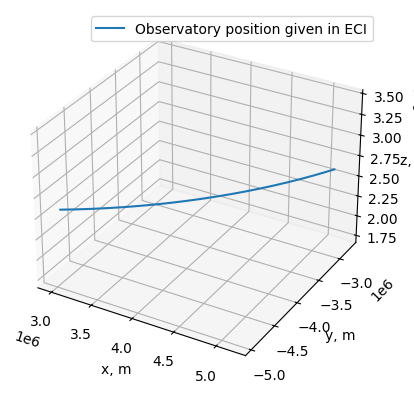

In [5]:
# Plots observatory ECI trajectory during time span

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(r_obs_eci_array[0,:], r_obs_eci_array[1,:], r_obs_eci_array[2,:], label='Observatory position given in ECI')
ax.set(xlabel='x, m', ylabel='y, m', zlabel='z, m')
ax.axis('equal') # makes the same axes scale
ax.grid()
ax.legend()
plt.show()
# plt.savefig("Observatory position trajectory wrt ECI.png")

In [5]:
# Defining satellite

# Choose option: 
# 0: input satellite NORAD ID or satellite catalogue number
# 1: upload TLE file and choose a satellite idx from the file

option = 0

if option == 0:
## inputs satellite TLE from CelesTrack by its NORAD ID or satellite catalogue number

    def get_tle_by_id(norad_id):
        url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle"
        
        response = requests.get(url)
        tle_lines = response.text.splitlines()
        
        for i in range(0, len(tle_lines), 3):  # Each TLE set is 3 lines: name, line1, line2
            if tle_lines[i+1].strip()[2:7] == str(norad_id):  # Check if NORAD ID matches
                return tle_lines[i], tle_lines[i+1], tle_lines[i+2]
        
        return None, None, None 
    
    # Input NORAD ID for the satellite
    norad_id = input("Enter the NORAD ID of the satellite: ")
    
    # Get the TLE data for the satellite
    satelliteName, TleFirstLine, TleSecondLine = get_tle_by_id(norad_id)
    satellite = Satrec.twoline2rv(TleFirstLine, TleSecondLine)
    print(satelliteName)
    print(TleFirstLine)
    print(TleSecondLine)
    
elif option == 1:
    # import text file with satellite TLE and choose one of the TLE data
    
    # Please enter text file name
    with open('Site_Visit_1_11_2024.txt', 'r') as file:
        lines = [line.strip() for line in file]
    
    # Please choose satellite indx 
    satIndx = 9
    satelliteName = lines[satIndx * 3]
    TleFirstLine = lines[satIndx * 3 + 1]
    TleSecondLine = lines[satIndx * 3 + 2]
    satellite = Satrec.twoline2rv(TleFirstLine, TleSecondLine)
    print(satelliteName)
    print(TleFirstLine)
    print(TleSecondLine)

else:
  raise Exception("please choose option 0, 1")


STARLINK-31113          
1 58668U 23211B   24316.65920137  .00002742  00000+0  11467-3 0  9997
2 58668  43.0027 290.4086 0001771 256.4569 103.6085 15.25902455 49906


In [6]:
# Propagates satellite state using SGP4 propagator for the given time span

r_sat_eci_array = np.empty([3, 0], float)

for jd in julian_dates:

    # Propagate
    e, r, v = satellite.sgp4(jd, 0)
    
    if e == 0:
        
        r_sat_eci_array = np.concatenate((r_sat_eci_array, np.vstack([r[0] * 1e3, r[1] * 1e3, r[2] * 1e3])), axis=1)

    else:
        print("Warning: SGP4 propagator failed")

gregorian_dates = Time(julian_dates, format='jd').to_datetime()



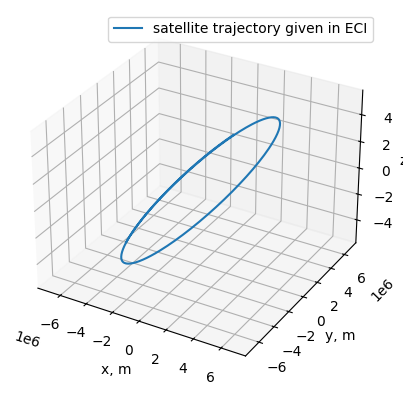

In [12]:
# Plots satellite trajectory within observation time span

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(r_sat_eci_array[0,:], r_sat_eci_array[1,:], r_sat_eci_array[2,:], label='satellite trajectory given in ECI')
ax.set(xlabel='x, m', ylabel='y, m', zlabel='z, m')
ax.grid()
ax.axis('equal')
ax.legend()
plt.show()
# plt.savefig("satellite trajectory.png")

In [7]:
# Calculates satellite elevation for the given t_span
# Checks if a satellite goes above minimum required elevation
#      if so, calculates R.A., Dec, azimuth and elevation/altitude and stores it together with corresponding time epoch

elevation_array = []
# 2D matrix, 5xNsteps with [Epoch, topocentric R.A. and Dec., azimuth, elevation]  coordinates of a satellite for the time when it's above minimum elevation
# Refer to the notebook introduction to see coordinates definition

celestial_coordinates_array = np.empty([5, 0], float) 

for time_idx in range(np.size(julian_dates)):

    r_relative = r_sat_eci_array[:, time_idx] - r_obs_eci_array[:, time_idx]
    e_relative = r_relative / np.linalg.norm(r_relative)
    e_obs = r_obs_eci_array[:, time_idx] / np.linalg.norm(r_obs_eci_array[:, time_idx])

    elevation = np.pi / 2 - np.arccos(np.dot(e_obs, e_relative))

    if elevation > elevation_min:
       
        right_ascension_topo, declination_topo = calc_ra_and_dec_topocentric(r_sat_eci_array[:, time_idx], r_obs_eci_array[:, time_idx]) # basically, it finds spherical angles
        local_azimuth, local_elevation = calc_azimuth_and_elevation(r_obs_eci_array[:, time_idx], r_sat_eci_array[:, time_idx])
       
        assert(np.absolute(elevation - local_elevation) < 1e-5) # checks if computed elevation using ECI frame based vectors coincides with the one computed in horizon reference frame
        
        RA  = degrees_to_hms(np.rad2deg(right_ascension_topo))
        RA_processed = f"{RA[0]}:{RA[1]}:{RA[2]:.6f}"
        DEC =  degrees_to_dms(np.rad2deg(declination_topo))
        DEC_processed = f"{DEC[0]}:{DEC[1]}:{DEC[2]:.6f}"

        celestial_coordinates_array = np.concatenate((celestial_coordinates_array, np.vstack([gregorian_dates[time_idx], RA_processed, DEC_processed, local_azimuth, local_elevation])), axis=1)

    elevation_array.append(elevation)

observation_condition = elevation_array > np.repeat(elevation_min, np.size(elevation_array))

celestial_coordinates_array_processed = celestial_coordinates_array.copy() # otherwise changes in array celestial_coordinates_array_processed will influence array celestial_coordinates_array
celestial_coordinates_array_processed = np.transpose(celestial_coordinates_array_processed)
celestial_coordinates_array_processed[:, 1] = celestial_coordinates_array_processed[:, 1] 
celestial_coordinates_array_processed[:, 2] = celestial_coordinates_array_processed[:, 2] 
celestial_coordinates_array_processed[:, 3] = celestial_coordinates_array_processed[:, 3] * 180 / np.pi
celestial_coordinates_array_processed[:, 4] = celestial_coordinates_array_processed[:, 4] * 180 / np.pi

celestial_coordinates_data = pd.DataFrame(celestial_coordinates_array_processed, columns=["Date and Time, UTC", "        R.A., h_m_s", "     Dec, deg_m_s", "     Az, deg",  "     Elev, deg"])

# to save data
filename = f'{satelliteName}_data.txt'  # Creates filenames like 'satellite1_data.txt', 'satellite2_data.txt', etc.
celestial_coordinates_data.to_csv(filename, sep='\t', index=False)


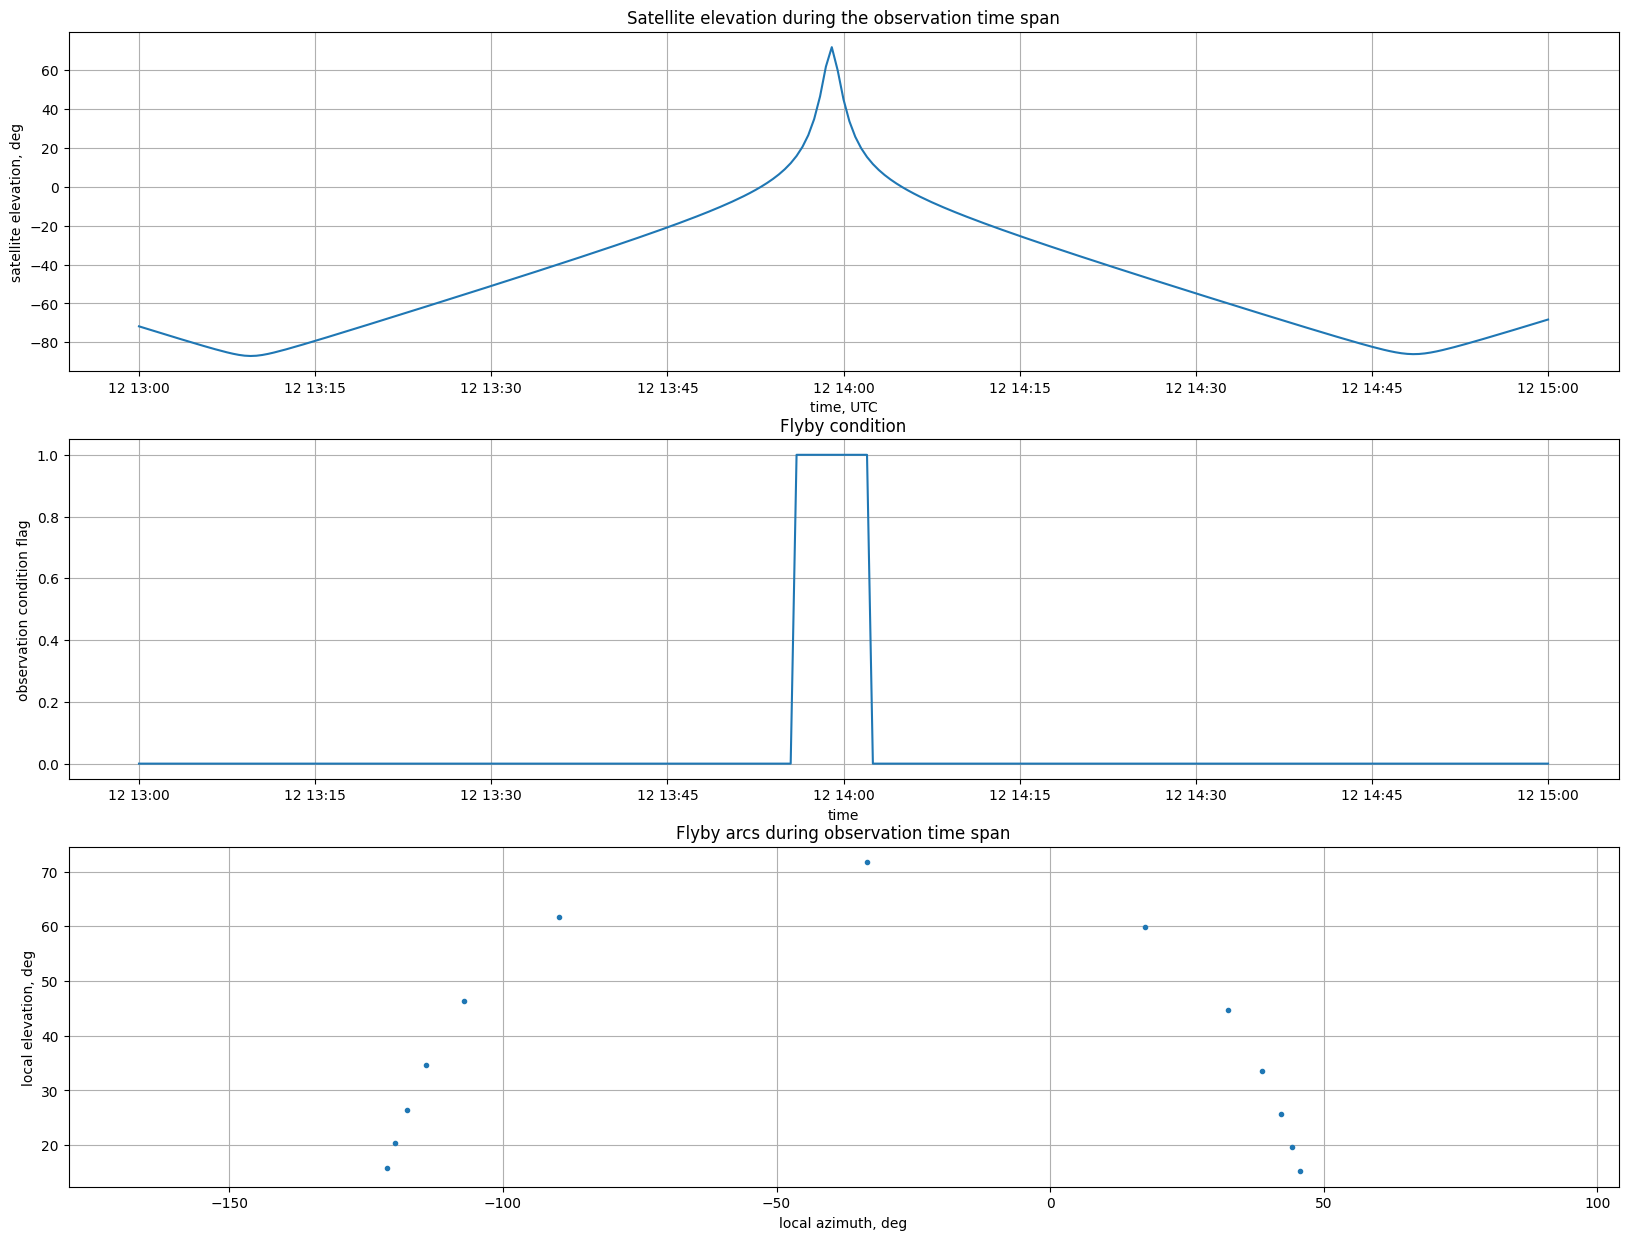

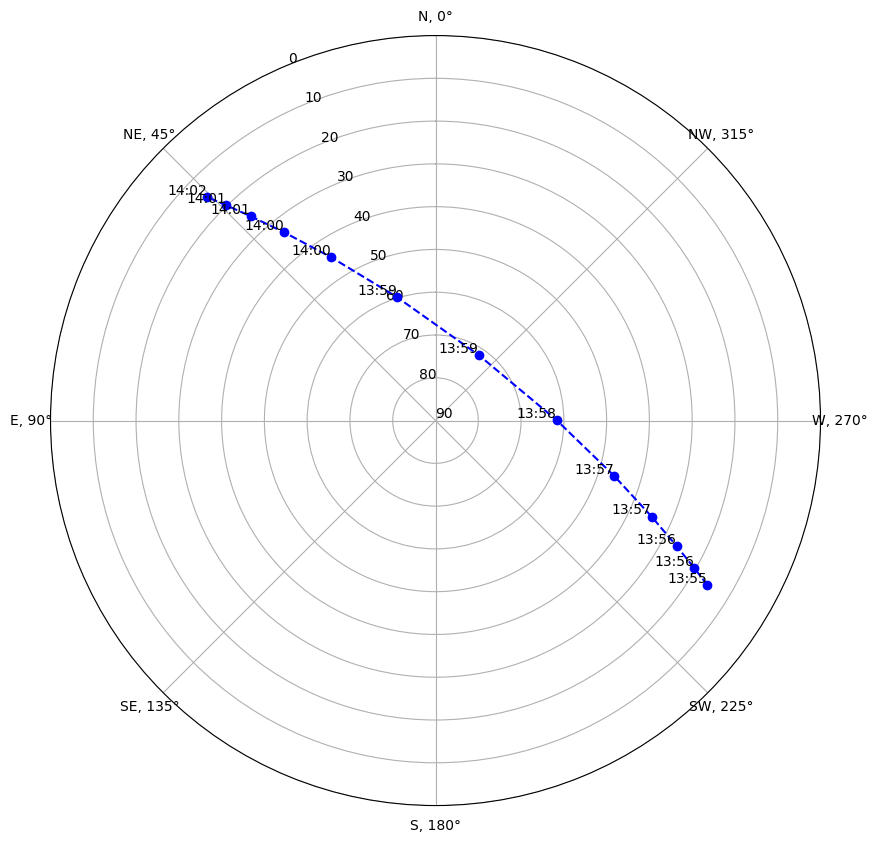

In [11]:
# Plots satellite elevation within time span

fig, axs = plt.subplots(3, 1, figsize=(20, 15))
axs[0].plot(t_span, np.rad2deg(elevation_array))

axs[0].set(xlabel='time, UTC', ylabel='satellite elevation, deg',
       title='Satellite elevation during the observation time span')
axs[0].grid()

# Flyby conditions
axs[1].plot(t_span, observation_condition)

axs[1].set(xlabel='time', ylabel='observation condition flag',
          title='Flyby condition')
axs[1].grid()

# Plots azimuth and elevation of the satellite during flyby if it take place (refer to angles definition in introduction to the notebook)
axs[2].plot(celestial_coordinates_array[3,:] * 180 / np. pi, celestial_coordinates_array[4,:] * 180 / np. pi, '.')

axs[2].set(xlabel='local azimuth, deg', ylabel='local elevation, deg',
       title='Flyby arcs during observation time span')
axs[2].axis('equal')
axs[2].grid()

plt.show()

# fig.savefig("satellite flyby arcs.png")

plot_sky_s(celestial_coordinates_array_processed[:, 3:5], celestial_coordinates_array_processed[:, 0])

In [12]:
# polar interactive plot
labels = []

for i in range(len(celestial_coordinates_array_processed)):
    labels.append(f"Azimuth: {360 - celestial_coordinates_array_processed [i, 3] % 360:.1f}°<br>Elevation: {celestial_coordinates_array_processed [i, 4]:.1f}°<br>RA: {celestial_coordinates_array_processed [i, 1]}<br>Dec: {celestial_coordinates_array_processed [i, 2]}<br>Time: {celestial_coordinates_array_processed [i, 0]}")


# Create an interactive polar plot with Plotly
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=celestial_coordinates_array_processed[:, 4],
    theta=celestial_coordinates_array_processed[:, 3] % 360,
    mode='lines+markers',
    marker=dict(color='orange', size=5),
    line=dict(color='orange'),
    text=labels,  # Add labels for each point
    textposition="top center",  # Position labels at the top center of each marker
    hoverinfo="text",  # Show text on hover
    name=" Satellite Trajectory"
))



# Customize layout to match previous appearance
fig.update_layout(
    polar=dict(
        bgcolor="midnightblue",  # Dark background color
        radialaxis=dict(
            range=[90, 0],  # 90 at center (zenith), 0 at edge (horizon)
            tickvals=[30, 60, 90],  # Tick values for altitude
            ticktext=['30°', '60°', 'Zenith'],  # Altitude labels
            tickfont=dict(color="white"),
            showline=False,
            showticklabels=True,
            ticks="",

            
        ),
        angularaxis=dict(
            direction="clockwise",
            rotation=90,  # Rotate to start at north
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            # tickvals=[0, 315, 270, 225, 180, 135, 90, 45],
            #ticktext=['N, 0°', 'NE, 45°', 'E, 90°', 'SE, 135°', 'S, 180°', 'SW, 225°', 'W, 270°', 'NW, 315°'],
            ticktext=['N, 0°', 'NW, 315°', 'W, 270°', 'SW, 225°', 'S, 180°', 'SE, 135°', 'E, 90°', 'NE, 45°'],
            tickfont=dict(color="lime", size=14)
        )
    ),
    title="Satellite Trajectory Above Abu Dhabi",
    font=dict(color="white"),
    showlegend=True,
    legend=dict(font=dict(size=10, color="white")),
    paper_bgcolor="midnightblue",  # Background color for the figure
    width=1500,  # Figure width
    height=1500  # Figure height
)

fig.show()

Observations can be started at  DatetimeIndex(['2024-11-01 14:00:30'], dtype='datetime64[ns]', freq=None) UTC


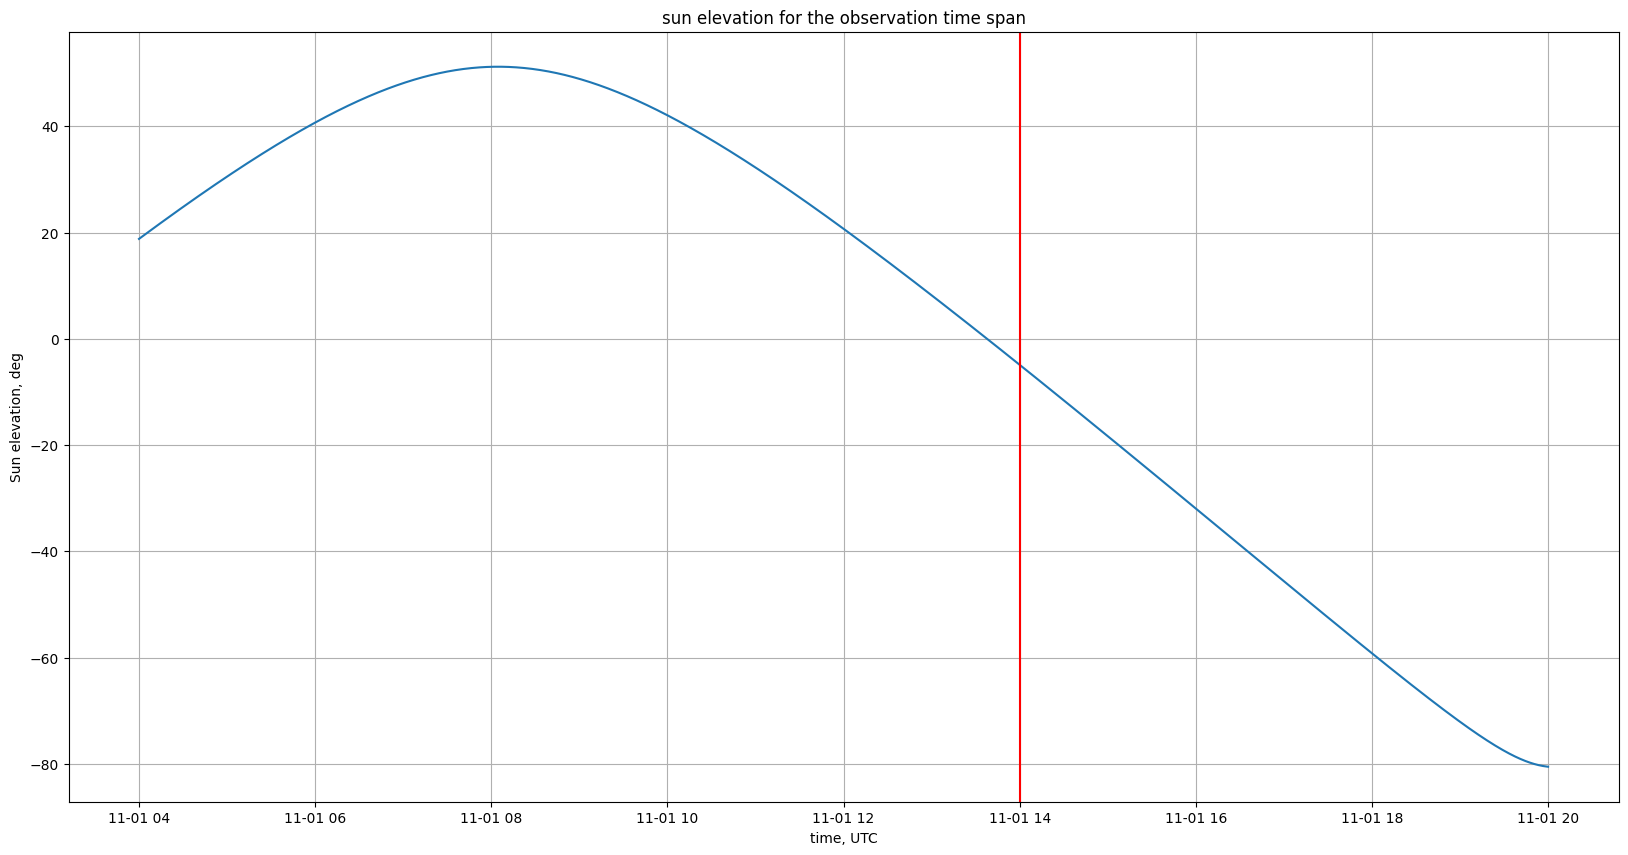

In [ ]:
# Calculates sun elevation angle with respect to the observation point during observation day
# Requires to understand when the observation can be done in terms of lighting conditions

start_date_obs_day = "2024-11-01 04:00:00" # given in UTC, 8 am in Abu Dhabi
end_date_obs_day = "2024-11-01 20:00:00"   # given in UTC, midnight in Abu Dhabi

maximum_elevation_sun_deg = -5 

# Generates a range of datetimes with certain time step
t_span_obs_day = pd.date_range(start=start_date_obs_day, end=end_date_obs_day, freq='30s')

# Converts to a list of strings if needed
gregorian_dates_obs_day = t_span_obs_day.strftime("%Y-%m-%d %H:%M:%S").tolist()
# Converts to Julian Date
julian_dates_obs_day = Time(gregorian_dates_obs_day, format='iso').jd


# Loads ephemeris data (required for accurate positions)
eph = load('de421.bsp')  # DE421 ephemeris, can be downloaded by Skyfield if not already cached
earth, sun = eph['earth'], eph['sun']
ts = load.timescale()

# Compute Sun's position relative to Earth
sunElevationArray_deg =  []
sunElevationArray_rad =  []

for jdIndx, jd in enumerate(julian_dates_obs_day):
    astrometric = earth.at(ts.tt_jd(jd)).observe(sun)
    distance, sun_vector = astrometric.distance().km, astrometric.position.km  # Get position vector in km
    
    eSun = sun_vector / np.linalg.norm(sun_vector)
    eSun = np.vstack([eSun[0], eSun[1], eSun[2]])
    r_obs_local = ecef_to_eci(r_obs_ecef, t_span_obs_day[jdIndx])
    eObs = r_obs_local / np.linalg.norm(r_obs_local)
    sunElevation = np.pi / 2 - np.arccos(np.dot(np.transpose(eObs), eSun))
    
    sunElevationArray_rad = np.concatenate((sunElevationArray_rad, np.array(sunElevation * 180 / np.pi).reshape(1)), axis=0)

    sunElevationArray_deg = np.concatenate((sunElevationArray_deg, np.array(sunElevation * 180 / np.pi).reshape(1)), axis=0)

observation_cond_logical = sunElevationArray_deg < maximum_elevation_sun_deg
idxs_array = np.argwhere(observation_cond_logical)
observation_time_start = t_span_obs_day[idxs_array[0]]

print('Observations can be started at ', observation_time_start,  'UTC')

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(t_span_obs_day , np.transpose(sunElevationArray_deg))
plt.axvline(x = observation_time_start, color = 'r', label = 'Observation time start')
ax.set(xlabel='time, UTC', ylabel='Sun elevation, deg',
       title='sun elevation for the observation time span')
ax.grid()

# fig.savefig("sun elevation.png")
plt.show()